# Sciplex Dose

In [1]:
ood_seed = 12

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('SAHA', '50.0'), 604)


Removed datapoint: 604

train         11398
validation     2809
ood             604
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 64%|██████▍   | 9491/14811 [00:00<00:00, 94900.36it/s]

100%|██████████| 14811/14811 [00:00<00:00, 94991.29it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 962681.49it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 148.59it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:04<27:43,  4.17s/it]

Epoch 1/400:   0%|          | 1/400 [00:04<27:43,  4.17s/it, v_num=1, recon=3.06e+3, r2_mean=0.125, adv_loss=1.53, acc_pert=0.315]

Epoch 2/400:   0%|          | 1/400 [00:04<27:43,  4.17s/it, v_num=1, recon=3.06e+3, r2_mean=0.125, adv_loss=1.53, acc_pert=0.315]

Epoch 2/400:   0%|          | 2/400 [00:07<24:12,  3.65s/it, v_num=1, recon=3.06e+3, r2_mean=0.125, adv_loss=1.53, acc_pert=0.315]

Epoch 2/400:   0%|          | 2/400 [00:07<24:12,  3.65s/it, v_num=1, recon=2.34e+3, r2_mean=0.48, adv_loss=1.28, acc_pert=0.507] 

Epoch 3/400:   0%|          | 2/400 [00:07<24:12,  3.65s/it, v_num=1, recon=2.34e+3, r2_mean=0.48, adv_loss=1.28, acc_pert=0.507]

Epoch 3/400:   1%|          | 3/400 [00:11<24:41,  3.73s/it, v_num=1, recon=2.34e+3, r2_mean=0.48, adv_loss=1.28, acc_pert=0.507]

Epoch 3/400:   1%|          | 3/400 [00:11<24:41,  3.73s/it, v_num=1, recon=2.18e+3, r2_mean=0.59, adv_loss=1.15, acc_pert=0.574]

Epoch 4/400:   1%|          | 3/400 [00:11<24:41,  3.73s/it, v_num=1, recon=2.18e+3, r2_mean=0.59, adv_loss=1.15, acc_pert=0.574]

Epoch 4/400:   1%|          | 4/400 [00:14<23:32,  3.57s/it, v_num=1, recon=2.18e+3, r2_mean=0.59, adv_loss=1.15, acc_pert=0.574]

Epoch 4/400:   1%|          | 4/400 [00:14<23:32,  3.57s/it, v_num=1, recon=2.14e+3, r2_mean=0.661, adv_loss=1.04, acc_pert=0.616]

Epoch 5/400:   1%|          | 4/400 [00:14<23:32,  3.57s/it, v_num=1, recon=2.14e+3, r2_mean=0.661, adv_loss=1.04, acc_pert=0.616]

Epoch 5/400:   1%|▏         | 5/400 [00:17<22:45,  3.46s/it, v_num=1, recon=2.14e+3, r2_mean=0.661, adv_loss=1.04, acc_pert=0.616]

Epoch 5/400:   1%|▏         | 5/400 [00:17<22:45,  3.46s/it, v_num=1, recon=2.12e+3, r2_mean=0.707, adv_loss=0.974, acc_pert=0.639]

Epoch 6/400:   1%|▏         | 5/400 [00:17<22:45,  3.46s/it, v_num=1, recon=2.12e+3, r2_mean=0.707, adv_loss=0.974, acc_pert=0.639]

Epoch 6/400:   2%|▏         | 6/400 [00:21<22:20,  3.40s/it, v_num=1, recon=2.12e+3, r2_mean=0.707, adv_loss=0.974, acc_pert=0.639]

Epoch 6/400:   2%|▏         | 6/400 [00:21<22:20,  3.40s/it, v_num=1, recon=2.1e+3, r2_mean=0.737, adv_loss=0.937, acc_pert=0.649] 

Epoch 7/400:   2%|▏         | 6/400 [00:21<22:20,  3.40s/it, v_num=1, recon=2.1e+3, r2_mean=0.737, adv_loss=0.937, acc_pert=0.649]

Epoch 7/400:   2%|▏         | 7/400 [00:24<22:00,  3.36s/it, v_num=1, recon=2.1e+3, r2_mean=0.737, adv_loss=0.937, acc_pert=0.649]

Epoch 7/400:   2%|▏         | 7/400 [00:24<22:00,  3.36s/it, v_num=1, recon=2.1e+3, r2_mean=0.759, adv_loss=0.907, acc_pert=0.67] 

Epoch 8/400:   2%|▏         | 7/400 [00:24<22:00,  3.36s/it, v_num=1, recon=2.1e+3, r2_mean=0.759, adv_loss=0.907, acc_pert=0.67]

Epoch 8/400:   2%|▏         | 8/400 [00:27<21:47,  3.34s/it, v_num=1, recon=2.1e+3, r2_mean=0.759, adv_loss=0.907, acc_pert=0.67]

Epoch 8/400:   2%|▏         | 8/400 [00:27<21:47,  3.34s/it, v_num=1, recon=2.09e+3, r2_mean=0.779, adv_loss=0.899, acc_pert=0.67]

Epoch 9/400:   2%|▏         | 8/400 [00:27<21:47,  3.34s/it, v_num=1, recon=2.09e+3, r2_mean=0.779, adv_loss=0.899, acc_pert=0.67]

Epoch 9/400:   2%|▏         | 9/400 [00:31<21:40,  3.33s/it, v_num=1, recon=2.09e+3, r2_mean=0.779, adv_loss=0.899, acc_pert=0.67]

Epoch 9/400:   2%|▏         | 9/400 [00:31<21:40,  3.33s/it, v_num=1, recon=2.09e+3, r2_mean=0.792, adv_loss=0.872, acc_pert=0.686]

Epoch 10/400:   2%|▏         | 9/400 [00:31<21:40,  3.33s/it, v_num=1, recon=2.09e+3, r2_mean=0.792, adv_loss=0.872, acc_pert=0.686]


disnt_basal = 0.39880631929438193

disnt_after = 0.4001200112571

val_r2_mean = 0.8119940866123545

val_r2_var = 0.30165987014770507


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:49<51:04,  7.86s/it, v_num=1, recon=2.09e+3, r2_mean=0.792, adv_loss=0.872, acc_pert=0.686]

Epoch 10/400:   2%|▎         | 10/400 [00:49<51:04,  7.86s/it, v_num=1, recon=2.08e+3, r2_mean=0.807, adv_loss=0.871, acc_pert=0.688, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:49<51:04,  7.86s/it, v_num=1, recon=2.08e+3, r2_mean=0.807, adv_loss=0.871, acc_pert=0.688, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:52<42:54,  6.62s/it, v_num=1, recon=2.08e+3, r2_mean=0.807, adv_loss=0.871, acc_pert=0.688, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:52<42:54,  6.62s/it, v_num=1, recon=2.08e+3, r2_mean=0.821, adv_loss=0.859, acc_pert=0.692, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:52<42:54,  6.62s/it, v_num=1, recon=2.08e+3, r2_mean=0.821, adv_loss=0.859, acc_pert=0.692, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:56<36:21,  5.62s/it, v_num=1, recon=2.08e+3, r2_mean=0.821, adv_loss=0.859, acc_pert=0.692, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:56<36:21,  5.62s/it, v_num=1, recon=2.07e+3, r2_mean=0.832, adv_loss=0.847, acc_pert=0.7, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]  

Epoch 13/400:   3%|▎         | 12/400 [00:56<36:21,  5.62s/it, v_num=1, recon=2.07e+3, r2_mean=0.832, adv_loss=0.847, acc_pert=0.7, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:59<31:55,  4.95s/it, v_num=1, recon=2.07e+3, r2_mean=0.832, adv_loss=0.847, acc_pert=0.7, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:59<31:55,  4.95s/it, v_num=1, recon=2.08e+3, r2_mean=0.843, adv_loss=0.846, acc_pert=0.695, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:59<31:55,  4.95s/it, v_num=1, recon=2.08e+3, r2_mean=0.843, adv_loss=0.846, acc_pert=0.695, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:02<28:44,  4.47s/it, v_num=1, recon=2.08e+3, r2_mean=0.843, adv_loss=0.846, acc_pert=0.695, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:02<28:44,  4.47s/it, v_num=1, recon=2.07e+3, r2_mean=0.847, adv_loss=0.833, acc_pert=0.701, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:02<28:44,  4.47s/it, v_num=1, recon=2.07e+3, r2_mean=0.847, adv_loss=0.833, acc_pert=0.701, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:06<26:33,  4.14s/it, v_num=1, recon=2.07e+3, r2_mean=0.847, adv_loss=0.833, acc_pert=0.701, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:06<26:33,  4.14s/it, v_num=1, recon=2.07e+3, r2_mean=0.856, adv_loss=0.829, acc_pert=0.701, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [01:06<26:33,  4.14s/it, v_num=1, recon=2.07e+3, r2_mean=0.856, adv_loss=0.829, acc_pert=0.701, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:09<24:58,  3.90s/it, v_num=1, recon=2.07e+3, r2_mean=0.856, adv_loss=0.829, acc_pert=0.701, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:09<24:58,  3.90s/it, v_num=1, recon=2.07e+3, r2_mean=0.861, adv_loss=0.831, acc_pert=0.698, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:09<24:58,  3.90s/it, v_num=1, recon=2.07e+3, r2_mean=0.861, adv_loss=0.831, acc_pert=0.698, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:13<23:56,  3.75s/it, v_num=1, recon=2.07e+3, r2_mean=0.861, adv_loss=0.831, acc_pert=0.698, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:13<23:56,  3.75s/it, v_num=1, recon=2.06e+3, r2_mean=0.863, adv_loss=0.831, acc_pert=0.701, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:13<23:56,  3.75s/it, v_num=1, recon=2.06e+3, r2_mean=0.863, adv_loss=0.831, acc_pert=0.701, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:16<23:13,  3.65s/it, v_num=1, recon=2.06e+3, r2_mean=0.863, adv_loss=0.831, acc_pert=0.701, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:16<23:13,  3.65s/it, v_num=1, recon=2.06e+3, r2_mean=0.87, adv_loss=0.814, acc_pert=0.703, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [01:16<23:13,  3.65s/it, v_num=1, recon=2.06e+3, r2_mean=0.87, adv_loss=0.814, acc_pert=0.703, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:19<22:43,  3.58s/it, v_num=1, recon=2.06e+3, r2_mean=0.87, adv_loss=0.814, acc_pert=0.703, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:19<22:43,  3.58s/it, v_num=1, recon=2.06e+3, r2_mean=0.873, adv_loss=0.811, acc_pert=0.705, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:19<22:43,  3.58s/it, v_num=1, recon=2.06e+3, r2_mean=0.873, adv_loss=0.811, acc_pert=0.705, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]


disnt_basal = 0.41353807176903795

disnt_after = 0.4149683436219391

val_r2_mean = 0.8719847711649806

val_r2_var = 0.3581204452297904


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:39<53:54,  8.51s/it, v_num=1, recon=2.06e+3, r2_mean=0.873, adv_loss=0.811, acc_pert=0.705, val_recon=2.07e+3, disnt_basal=0.399, disnt_after=0.4, val_r2_mean=0.812, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:39<53:54,  8.51s/it, v_num=1, recon=2.06e+3, r2_mean=0.877, adv_loss=0.809, acc_pert=0.705, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:39<53:54,  8.51s/it, v_num=1, recon=2.06e+3, r2_mean=0.877, adv_loss=0.809, acc_pert=0.705, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:43<44:16,  7.01s/it, v_num=1, recon=2.06e+3, r2_mean=0.877, adv_loss=0.809, acc_pert=0.705, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:43<44:16,  7.01s/it, v_num=1, recon=2.05e+3, r2_mean=0.878, adv_loss=0.806, acc_pert=0.713, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:43<44:16,  7.01s/it, v_num=1, recon=2.05e+3, r2_mean=0.878, adv_loss=0.806, acc_pert=0.713, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:46<37:29,  5.95s/it, v_num=1, recon=2.05e+3, r2_mean=0.878, adv_loss=0.806, acc_pert=0.713, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:46<37:29,  5.95s/it, v_num=1, recon=2.05e+3, r2_mean=0.879, adv_loss=0.807, acc_pert=0.71, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [01:46<37:29,  5.95s/it, v_num=1, recon=2.05e+3, r2_mean=0.879, adv_loss=0.807, acc_pert=0.71, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:50<32:39,  5.20s/it, v_num=1, recon=2.05e+3, r2_mean=0.879, adv_loss=0.807, acc_pert=0.71, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:50<32:39,  5.20s/it, v_num=1, recon=2.05e+3, r2_mean=0.882, adv_loss=0.81, acc_pert=0.706, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:50<32:39,  5.20s/it, v_num=1, recon=2.05e+3, r2_mean=0.882, adv_loss=0.81, acc_pert=0.706, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:53<28:59,  4.63s/it, v_num=1, recon=2.05e+3, r2_mean=0.882, adv_loss=0.81, acc_pert=0.706, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:53<28:59,  4.63s/it, v_num=1, recon=2.05e+3, r2_mean=0.883, adv_loss=0.797, acc_pert=0.71, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:53<28:59,  4.63s/it, v_num=1, recon=2.05e+3, r2_mean=0.883, adv_loss=0.797, acc_pert=0.71, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:56<26:31,  4.24s/it, v_num=1, recon=2.05e+3, r2_mean=0.883, adv_loss=0.797, acc_pert=0.71, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:56<26:31,  4.24s/it, v_num=1, recon=2.05e+3, r2_mean=0.882, adv_loss=0.782, acc_pert=0.716, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:56<26:31,  4.24s/it, v_num=1, recon=2.05e+3, r2_mean=0.882, adv_loss=0.782, acc_pert=0.716, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:00<24:47,  3.98s/it, v_num=1, recon=2.05e+3, r2_mean=0.882, adv_loss=0.782, acc_pert=0.716, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:00<24:47,  3.98s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.788, acc_pert=0.713, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [02:00<24:47,  3.98s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.788, acc_pert=0.713, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:03<23:30,  3.78s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.788, acc_pert=0.713, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:03<23:30,  3.78s/it, v_num=1, recon=2.04e+3, r2_mean=0.883, adv_loss=0.773, acc_pert=0.724, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [02:03<23:30,  3.78s/it, v_num=1, recon=2.04e+3, r2_mean=0.883, adv_loss=0.773, acc_pert=0.724, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:06<22:33,  3.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.883, adv_loss=0.773, acc_pert=0.724, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:06<22:33,  3.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.776, acc_pert=0.721, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [02:06<22:33,  3.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.776, acc_pert=0.721, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:10<21:55,  3.55s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.776, acc_pert=0.721, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:10<21:55,  3.55s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.774, acc_pert=0.724, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [02:10<21:55,  3.55s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.774, acc_pert=0.724, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]


disnt_basal = 0.41634405881990805

disnt_after = 0.4172833329726787

val_r2_mean = 0.8861593295227395

val_r2_var = 0.36885563243519176


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:31<55:05,  8.93s/it, v_num=1, recon=2.04e+3, r2_mean=0.886, adv_loss=0.774, acc_pert=0.724, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.872, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:31<55:05,  8.93s/it, v_num=1, recon=2.03e+3, r2_mean=0.886, adv_loss=0.771, acc_pert=0.718, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:31<55:05,  8.93s/it, v_num=1, recon=2.03e+3, r2_mean=0.886, adv_loss=0.771, acc_pert=0.718, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:35<44:35,  7.25s/it, v_num=1, recon=2.03e+3, r2_mean=0.886, adv_loss=0.771, acc_pert=0.718, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:35<44:35,  7.25s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.778, acc_pert=0.717, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [02:35<44:35,  7.25s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.778, acc_pert=0.717, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:38<37:22,  6.09s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.778, acc_pert=0.717, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:38<37:22,  6.09s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.765, acc_pert=0.72, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [02:38<37:22,  6.09s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.765, acc_pert=0.72, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:41<32:17,  5.28s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.765, acc_pert=0.72, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:41<32:17,  5.28s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.764, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:41<32:17,  5.28s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.764, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:45<28:38,  4.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.764, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:45<28:38,  4.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.76, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:45<28:38,  4.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.76, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:48<26:39,  4.38s/it, v_num=1, recon=2.03e+3, r2_mean=0.888, adv_loss=0.76, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:48<26:39,  4.38s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.76, acc_pert=0.723, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:48<26:39,  4.38s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.76, acc_pert=0.723, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:52<24:37,  4.06s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.76, acc_pert=0.723, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:52<24:37,  4.06s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.763, acc_pert=0.719, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:52<24:37,  4.06s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.763, acc_pert=0.719, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:55<23:02,  3.81s/it, v_num=1, recon=2.02e+3, r2_mean=0.889, adv_loss=0.763, acc_pert=0.719, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:55<23:02,  3.81s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.752, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:55<23:02,  3.81s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.752, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:58<21:57,  3.64s/it, v_num=1, recon=2.02e+3, r2_mean=0.888, adv_loss=0.752, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:58<21:57,  3.64s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.749, acc_pert=0.728, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan] 

Epoch 39/400:  10%|▉         | 38/400 [02:58<21:57,  3.64s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.749, acc_pert=0.728, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:01<21:03,  3.50s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.749, acc_pert=0.728, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:01<21:03,  3.50s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.76, acc_pert=0.722, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan] 

Epoch 40/400:  10%|▉         | 39/400 [03:01<21:03,  3.50s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.76, acc_pert=0.722, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.420760974620989

disnt_after = 0.42208653116039674

val_r2_mean = 0.8924833595752716

val_r2_var = 0.3902484720403498


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:20<48:13,  8.04s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.76, acc_pert=0.722, val_recon=2.04e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:20<48:13,  8.04s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.753, acc_pert=0.724, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [03:20<48:13,  8.04s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.753, acc_pert=0.724, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:25<42:39,  7.13s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.753, acc_pert=0.724, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:25<42:39,  7.13s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.755, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:25<42:39,  7.13s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.755, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:29<36:29,  6.12s/it, v_num=1, recon=2.02e+3, r2_mean=0.89, adv_loss=0.755, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:29<36:29,  6.12s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.754, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:29<36:29,  6.12s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.754, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:32<32:08,  5.40s/it, v_num=1, recon=2.01e+3, r2_mean=0.889, adv_loss=0.754, acc_pert=0.732, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:32<32:08,  5.40s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.745, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [03:32<32:08,  5.40s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.745, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:36<29:00,  4.89s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.745, acc_pert=0.729, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:36<29:00,  4.89s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.743, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [03:36<29:00,  4.89s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.743, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:40<26:43,  4.52s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.743, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:40<26:43,  4.52s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.738, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:40<26:43,  4.52s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.738, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:43<25:09,  4.26s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.738, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:43<25:09,  4.26s/it, v_num=1, recon=2e+3, r2_mean=0.891, adv_loss=0.743, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]   

Epoch 47/400:  12%|█▏        | 46/400 [03:43<25:09,  4.26s/it, v_num=1, recon=2e+3, r2_mean=0.891, adv_loss=0.743, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:49<27:15,  4.63s/it, v_num=1, recon=2e+3, r2_mean=0.891, adv_loss=0.743, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:49<27:15,  4.63s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.734, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [03:49<27:15,  4.63s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.734, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:53<25:27,  4.34s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.734, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:53<25:27,  4.34s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.73, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan] 

Epoch 49/400:  12%|█▏        | 48/400 [03:53<25:27,  4.34s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.73, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:56<24:13,  4.14s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.73, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:56<24:13,  4.14s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.747, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]  

Epoch 50/400:  12%|█▏        | 49/400 [03:56<24:13,  4.14s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.747, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.4241710155470202

disnt_after = 0.42531390272215364

val_r2_mean = 0.8922750771045684

val_r2_var = 0.40658044002272864


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [04:12<43:35,  7.47s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.747, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.892, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:12<43:35,  7.47s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.727, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [04:12<43:35,  7.47s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.727, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:15<36:28,  6.27s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.727, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:15<36:28,  6.27s/it, v_num=1, recon=2e+3, r2_mean=0.892, adv_loss=0.727, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]   

Epoch 52/400:  13%|█▎        | 51/400 [04:15<36:28,  6.27s/it, v_num=1, recon=2e+3, r2_mean=0.892, adv_loss=0.727, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:18<31:04,  5.36s/it, v_num=1, recon=2e+3, r2_mean=0.892, adv_loss=0.727, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:18<31:04,  5.36s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:18<31:04,  5.36s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:21<27:15,  4.71s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:21<27:15,  4.71s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.739, acc_pert=0.734, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]   

Epoch 54/400:  13%|█▎        | 53/400 [04:21<27:15,  4.71s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.739, acc_pert=0.734, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:25<24:45,  4.29s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.739, acc_pert=0.734, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:25<24:45,  4.29s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.725, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [04:25<24:45,  4.29s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.725, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:28<22:58,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.725, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:28<22:58,  4.00s/it, v_num=1, recon=1.99e+3, r2_mean=0.893, adv_loss=0.724, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [04:28<22:58,  4.00s/it, v_num=1, recon=1.99e+3, r2_mean=0.893, adv_loss=0.724, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:31<21:36,  3.77s/it, v_num=1, recon=1.99e+3, r2_mean=0.893, adv_loss=0.724, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:31<21:36,  3.77s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.734, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [04:31<21:36,  3.77s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.734, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:35<20:48,  3.64s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.734, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:35<20:48,  3.64s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.732, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [04:35<20:48,  3.64s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.732, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:38<20:04,  3.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.732, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:38<20:04,  3.52s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.728, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]   

Epoch 59/400:  14%|█▍        | 58/400 [04:38<20:04,  3.52s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.728, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:41<19:31,  3.43s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.728, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:41<19:31,  3.43s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.724, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [04:41<19:31,  3.43s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.724, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.4232544378404411

disnt_after = 0.4244432694171189

val_r2_mean = 0.8950263017957863

val_r2_var = 0.4138616746122187


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [04:54<35:30,  6.27s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.724, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.892, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [04:54<35:30,  6.27s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.722, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [04:54<35:30,  6.27s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.722, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [04:58<31:11,  5.52s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.722, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [04:58<31:11,  5.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [04:58<31:11,  5.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:01<27:30,  4.88s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:01<27:30,  4.88s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.727, acc_pert=0.735, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [05:01<27:30,  4.88s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.727, acc_pert=0.735, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:05<25:21,  4.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.727, acc_pert=0.735, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:05<25:21,  4.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.728, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [05:05<25:21,  4.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.728, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:09<24:17,  4.34s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.728, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:09<24:17,  4.34s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.72, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]  

Epoch 65/400:  16%|█▌        | 64/400 [05:09<24:17,  4.34s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.72, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:12<23:08,  4.14s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.72, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:12<23:08,  4.14s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:12<23:08,  4.14s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:16<22:38,  4.07s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:16<22:38,  4.07s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.713, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:16<22:38,  4.07s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.713, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:21<23:20,  4.21s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.713, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:21<23:20,  4.21s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.707, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [05:21<23:20,  4.21s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.707, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:24<21:43,  3.93s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.707, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:24<21:43,  3.93s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.717, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [05:24<21:43,  3.93s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.717, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:27<20:33,  3.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.717, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:27<20:33,  3.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.725, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [05:27<20:33,  3.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.725, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.42640470398908314

disnt_after = 0.42752774948005157

val_r2_mean = 0.8929829391566187

val_r2_var = 0.4245400943539359


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [05:48<48:28,  8.81s/it, v_num=1, recon=1.98e+3, r2_mean=0.895, adv_loss=0.725, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [05:48<48:28,  8.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.706, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [05:48<48:28,  8.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.706, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:52<39:56,  7.29s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.706, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:52<39:56,  7.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.715, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [05:52<39:56,  7.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.715, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [05:55<33:13,  6.08s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.715, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [05:55<33:13,  6.08s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [05:55<33:13,  6.08s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [05:58<28:31,  5.23s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [05:58<28:31,  5.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.723, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [05:58<28:31,  5.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.723, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:02<25:09,  4.63s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.723, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:02<25:09,  4.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.713, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [06:02<25:09,  4.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.713, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:05<22:50,  4.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.713, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:05<22:50,  4.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [06:05<22:50,  4.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:08<21:15,  3.94s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:08<21:15,  3.94s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan] 

Epoch 77/400:  19%|█▉        | 76/400 [06:08<21:15,  3.94s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:11<20:00,  3.72s/it, v_num=1, recon=1.97e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:11<20:00,  3.72s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:11<20:00,  3.72s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:15<19:17,  3.59s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:15<19:17,  3.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.715, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [06:15<19:17,  3.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.715, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:18<18:40,  3.49s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.715, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:18<18:40,  3.49s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.697, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [06:18<18:40,  3.49s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.697, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.4184904217350127

disnt_after = 0.4196244557266944

val_r2_mean = 0.8986057747494091

val_r2_var = 0.4295629674738104


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [06:43<52:32,  9.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.697, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.893, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [06:43<52:32,  9.85s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.712, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [06:43<52:32,  9.85s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.712, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:49<46:16,  8.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.712, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:49<46:16,  8.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.71, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [06:49<46:16,  8.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.71, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:52<38:18,  7.23s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.71, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:52<38:18,  7.23s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.71, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [06:52<38:18,  7.23s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.71, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:56<32:47,  6.21s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.71, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:56<32:47,  6.21s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.712, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [06:56<32:47,  6.21s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.712, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:00<28:48,  5.47s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.712, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:00<28:48,  5.47s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [07:00<28:48,  5.47s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:04<26:00,  4.95s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:04<26:00,  4.95s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]  

Epoch 86/400:  21%|██▏       | 85/400 [07:04<26:00,  4.95s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:07<24:05,  4.60s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:07<24:05,  4.60s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.708, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [07:07<24:05,  4.60s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.708, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:11<22:41,  4.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.708, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:11<22:41,  4.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [07:11<22:41,  4.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:15<21:39,  4.17s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:15<21:39,  4.17s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]  

Epoch 89/400:  22%|██▏       | 88/400 [07:15<21:39,  4.17s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:19<21:01,  4.06s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:19<21:01,  4.06s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [07:19<21:01,  4.06s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.41978434108716234

disnt_after = 0.4210131031794548

val_r2_mean = 0.8980219640515069

val_r2_var = 0.42836812842975963

Epoch 90/400:  22%|██▎       | 90/400 [07:44<53:46, 10.41s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.899, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [07:44<53:46, 10.41s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.744, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]    

Epoch 91/400:  22%|██▎       | 90/400 [07:44<53:46, 10.41s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.744, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:49<45:31,  8.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.744, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:49<45:31,  8.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.698, acc_pert=0.747, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [07:49<45:31,  8.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.698, acc_pert=0.747, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:52<36:52,  7.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.698, acc_pert=0.747, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:52<36:52,  7.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [07:52<36:52,  7.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:56<30:48,  6.02s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:56<30:48,  6.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.692, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [07:56<30:48,  6.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.692, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:59<26:32,  5.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.896, adv_loss=0.692, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:59<26:32,  5.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.689, acc_pert=0.745, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [07:59<26:32,  5.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.689, acc_pert=0.745, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:02<23:32,  4.63s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.689, acc_pert=0.745, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:02<23:32,  4.63s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [08:02<23:32,  4.63s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:06<21:13,  4.19s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:06<21:13,  4.19s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.707, acc_pert=0.743, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [08:06<21:13,  4.19s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.707, acc_pert=0.743, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:09<19:38,  3.89s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.707, acc_pert=0.743, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:09<19:38,  3.89s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.703, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [08:09<19:38,  3.89s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.703, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:12<18:36,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.703, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:12<18:36,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [08:12<18:36,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:16<18:19,  3.65s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:16<18:19,  3.65s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [08:16<18:19,  3.65s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4214090531205525

disnt_after = 0.42195900389145174

val_r2_mean = 0.8972430408000949

val_r2_var = 0.43748262795535003


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [08:42<52:25, 10.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.898, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:42<52:25, 10.48s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [08:42<52:25, 10.48s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:45<41:18,  8.29s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:45<41:18,  8.29s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.745, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [08:45<41:18,  8.29s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.745, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:49<33:56,  6.83s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.745, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:49<33:56,  6.83s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.697, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [08:49<33:56,  6.83s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.697, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:52<28:28,  5.75s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.697, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:52<28:28,  5.75s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.699, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [08:52<28:28,  5.75s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.699, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:55<24:37,  4.99s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.699, acc_pert=0.748, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:55<24:37,  4.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.691, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [08:55<24:37,  4.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.691, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:58<21:57,  4.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.691, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:58<21:57,  4.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.696, acc_pert=0.746, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [08:58<21:57,  4.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.696, acc_pert=0.746, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [09:01<20:07,  4.11s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.696, acc_pert=0.746, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [09:01<20:07,  4.11s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [09:01<20:07,  4.11s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:05<18:45,  3.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:05<18:45,  3.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [09:05<18:45,  3.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:08<17:47,  3.66s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:08<17:47,  3.66s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.701, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [09:08<17:47,  3.66s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.701, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:11<17:08,  3.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.701, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:11<17:08,  3.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.744, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]  

Epoch 110/400:  27%|██▋       | 109/400 [09:11<17:08,  3.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.744, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4184352332748362

disnt_after = 0.41951602243889247

val_r2_mean = 0.8928129748864606

val_r2_var = 0.4422137065367265

Epoch 110/400:  28%|██▊       | 110/400 [09:35<46:53,  9.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.744, val_recon=2e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [09:35<46:53,  9.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [09:35<46:53,  9.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:40<39:56,  8.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:40<39:56,  8.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [09:40<39:56,  8.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:44<32:34,  6.79s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:44<32:34,  6.79s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [09:44<32:34,  6.79s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:47<27:21,  5.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:47<27:21,  5.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [09:47<27:21,  5.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:50<23:38,  4.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:50<23:38,  4.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.684, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [09:50<23:38,  4.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.684, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:53<21:08,  4.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.684, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:53<21:08,  4.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [09:53<21:08,  4.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:57<19:24,  4.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:57<19:24,  4.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.747, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]  

Epoch 117/400:  29%|██▉       | 116/400 [09:57<19:24,  4.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.747, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:00<18:06,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.747, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:00<18:06,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [10:00<18:06,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:03<17:18,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:03<17:18,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.746, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [10:03<17:18,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.746, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:06<16:43,  3.57s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.746, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:06<16:43,  3.57s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]  

Epoch 120/400:  30%|██▉       | 119/400 [10:06<16:43,  3.57s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.41933592680267834

disnt_after = 0.4203633641269062

val_r2_mean = 0.8919927862557497

val_r2_var = 0.43103798844597563

Epoch 120/400:  30%|███       | 120/400 [10:21<32:40,  7.00s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [10:21<32:40,  7.00s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [10:21<32:40,  7.00s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:25<27:27,  5.90s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:25<27:27,  5.90s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [10:25<27:27,  5.90s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:28<23:51,  5.15s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:28<23:51,  5.15s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [10:28<23:51,  5.15s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:31<21:09,  4.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:31<21:09,  4.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [10:31<21:09,  4.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:35<19:25,  4.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:35<19:25,  4.22s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan] 

Epoch 125/400:  31%|███       | 124/400 [10:35<19:25,  4.22s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:41<22:04,  4.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:41<22:04,  4.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [10:41<22:04,  4.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:44<19:54,  4.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:44<19:54,  4.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan] 

Epoch 127/400:  32%|███▏      | 126/400 [10:44<19:54,  4.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:48<18:21,  4.03s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:48<18:21,  4.03s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [10:48<18:21,  4.03s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:51<17:32,  3.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:51<17:32,  3.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan] 

Epoch 129/400:  32%|███▏      | 128/400 [10:51<17:32,  3.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:54<16:41,  3.69s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:54<16:41,  3.69s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.674, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [10:54<16:41,  3.69s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.674, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.41886397894995275

disnt_after = 0.4204106448679191

val_r2_mean = 0.8915306291796944

val_r2_var = 0.44207909053022204

Epoch 130/400:  32%|███▎      | 130/400 [11:17<42:10,  9.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.674, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [11:17<42:10,  9.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [11:17<42:10,  9.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:23<38:04,  8.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:23<38:04,  8.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [11:23<38:04,  8.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:27<31:15,  7.00s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:27<31:15,  7.00s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.674, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]  

Epoch 133/400:  33%|███▎      | 132/400 [11:27<31:15,  7.00s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.674, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:30<26:07,  5.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.674, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:30<26:07,  5.87s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.678, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [11:30<26:07,  5.87s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.678, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:33<22:27,  5.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.678, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:33<22:27,  5.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]  

Epoch 135/400:  34%|███▎      | 134/400 [11:33<22:27,  5.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:37<19:55,  4.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:37<19:55,  4.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [11:37<19:55,  4.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:40<18:18,  4.16s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:40<18:18,  4.16s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.675, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [11:40<18:18,  4.16s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.675, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:43<16:59,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.675, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:43<16:59,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [11:43<16:59,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:46<16:07,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:46<16:07,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]  

Epoch 139/400:  34%|███▍      | 138/400 [11:46<16:07,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:50<15:29,  3.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:50<15:29,  3.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [11:50<15:29,  3.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.415049455109102

disnt_after = 0.4157698510133183

val_r2_mean = 0.8922335039485586

val_r2_var = 0.4357174120166084

Epoch 140/400:  35%|███▌      | 140/400 [12:06<31:37,  7.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.695, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.892, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [12:06<31:37,  7.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [12:06<31:37,  7.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:09<26:49,  6.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:09<26:49,  6.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan] 

Epoch 142/400:  35%|███▌      | 141/400 [12:09<26:49,  6.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:13<23:43,  5.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:13<23:43,  5.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [12:13<23:43,  5.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:16<20:45,  4.85s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:16<20:45,  4.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [12:16<20:45,  4.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:20<18:43,  4.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:20<18:43,  4.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.686, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [12:20<18:43,  4.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.686, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:24<18:01,  4.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.686, acc_pert=0.751, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:24<18:01,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]  

Epoch 146/400:  36%|███▋      | 145/400 [12:24<18:01,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:27<16:46,  3.96s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:27<16:46,  3.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan] 

Epoch 147/400:  36%|███▋      | 146/400 [12:27<16:46,  3.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:30<15:46,  3.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:30<15:46,  3.74s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [12:30<15:46,  3.74s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:34<15:14,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:34<15:14,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [12:34<15:14,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:37<14:43,  3.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:37<14:43,  3.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]  

Epoch 150/400:  37%|███▋      | 149/400 [12:37<14:43,  3.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.4177498780853826

disnt_after = 0.41893955302216257

val_r2_mean = 0.8986364310437984

val_r2_var = 0.43948214704340155


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [12:59<37:23,  8.97s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [12:59<37:23,  8.97s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [12:59<37:23,  8.97s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [13:02<30:12,  7.28s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [13:02<30:12,  7.28s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.662, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [13:02<30:12,  7.28s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.662, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [13:05<25:19,  6.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.662, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [13:05<25:19,  6.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan] 

Epoch 153/400:  38%|███▊      | 152/400 [13:05<25:19,  6.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:09<21:46,  5.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:09<21:46,  5.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [13:09<21:46,  5.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:12<19:15,  4.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:12<19:15,  4.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [13:12<19:15,  4.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:15<17:31,  4.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:15<17:31,  4.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [13:15<17:31,  4.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:19<16:14,  4.00s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:19<16:14,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.667, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [13:19<16:14,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.667, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:22<15:18,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.667, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:22<15:18,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.744, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]   

Epoch 158/400:  39%|███▉      | 157/400 [13:22<15:18,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.744, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:25<14:41,  3.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.744, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:25<14:41,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [13:25<14:41,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:29<14:11,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:29<14:11,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [13:29<14:11,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.41660741818857866

disnt_after = 0.41749428536625693

val_r2_mean = 0.8937405066056686

val_r2_var = 0.4482312522151254

Epoch 160/400:  40%|████      | 160/400 [13:59<46:31, 11.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [13:59<46:31, 11.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.746, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [13:59<46:31, 11.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.746, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [14:06<40:40, 10.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.746, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [14:06<40:40, 10.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [14:06<40:40, 10.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [14:09<32:20,  8.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [14:09<32:20,  8.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.657, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan] 

Epoch 163/400:  40%|████      | 162/400 [14:09<32:20,  8.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.657, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [14:13<26:35,  6.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.657, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [14:13<26:35,  6.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [14:13<26:35,  6.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [14:16<22:25,  5.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [14:16<22:25,  5.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [14:16<22:25,  5.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [14:20<20:02,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [14:20<20:02,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.657, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [14:20<20:02,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.657, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [14:23<17:42,  4.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.657, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [14:23<17:42,  4.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.655, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [14:23<17:42,  4.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.655, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [14:26<16:06,  4.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.655, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [14:26<16:06,  4.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.655, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]  

Epoch 168/400:  42%|████▏     | 167/400 [14:26<16:06,  4.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.655, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:29<15:00,  3.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.9, adv_loss=0.655, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:29<15:00,  3.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [14:29<15:00,  3.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:40<22:35,  5.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:40<22:35,  5.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [14:40<22:35,  5.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4175613402269933

disnt_after = 0.41845735898803976

val_r2_mean = 0.893338403376666

val_r2_var = 0.45064893148162155

Epoch 170/400:  42%|████▎     | 170/400 [14:57<35:43,  9.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [14:57<35:43,  9.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [14:57<35:43,  9.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [15:01<28:40,  7.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [15:01<28:40,  7.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [15:01<28:40,  7.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [15:04<23:42,  6.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [15:04<23:42,  6.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [15:04<23:42,  6.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [15:07<20:12,  5.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [15:07<20:12,  5.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan] 

Epoch 174/400:  43%|████▎     | 173/400 [15:07<20:12,  5.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [15:10<17:45,  4.71s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [15:10<17:45,  4.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [15:10<17:45,  4.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [15:14<16:03,  4.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [15:14<16:03,  4.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [15:14<16:03,  4.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [15:17<14:47,  3.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [15:17<14:47,  3.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [15:17<14:47,  3.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:20<13:56,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:20<13:56,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [15:20<13:56,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:23<13:21,  3.61s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:23<13:21,  3.61s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [15:23<13:21,  3.61s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:27<12:56,  3.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:27<12:56,  3.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [15:27<12:56,  3.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.4176076023585711

disnt_after = 0.41895477125730735

val_r2_mean = 0.8919401325962762

val_r2_var = 0.455268277905204


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [15:46<30:45,  8.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.418, val_r2_mean=0.893, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [15:46<30:45,  8.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [15:46<30:45,  8.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [15:50<25:14,  6.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [15:50<25:14,  6.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.668, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [15:50<25:14,  6.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.668, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [15:53<21:15,  5.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.668, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [15:53<21:15,  5.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [15:53<21:15,  5.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [15:57<18:26,  5.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [15:57<18:26,  5.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [15:57<18:26,  5.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [16:00<16:27,  4.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [16:00<16:27,  4.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [16:00<16:27,  4.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [16:03<15:03,  4.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [16:03<15:03,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [16:03<15:03,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [16:07<14:02,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [16:07<14:02,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [16:07<14:02,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [16:16<19:48,  5.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [16:16<19:48,  5.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [16:16<19:48,  5.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [16:20<17:43,  5.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [16:20<17:43,  5.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [16:20<17:43,  5.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [16:23<15:52,  4.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [16:23<15:52,  4.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [16:23<15:52,  4.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.4171063927182947

disnt_after = 0.4186439291333128

val_r2_mean = 0.8979721995917231

val_r2_var = 0.4561750840057026


Epoch 00189: cpa_metric reached. Module best state updated.


Epoch 190/400:  48%|████▊     | 190/400 [16:40<28:59,  8.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [16:40<28:59,  8.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [16:40<28:59,  8.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [16:45<25:26,  7.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [16:45<25:26,  7.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan] 

Epoch 192/400:  48%|████▊     | 191/400 [16:45<25:26,  7.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [16:49<21:11,  6.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [16:49<21:11,  6.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [16:49<21:11,  6.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [16:52<18:12,  5.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [16:52<18:12,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.689, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [16:52<18:12,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.689, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [16:57<17:49,  5.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.689, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [16:57<17:49,  5.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [16:57<17:49,  5.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [17:00<15:58,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [17:00<15:58,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [17:00<15:58,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [17:04<14:40,  4.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [17:04<14:40,  4.31s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.673, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [17:04<14:40,  4.31s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.673, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [17:07<13:36,  4.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.673, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [17:07<13:36,  4.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [17:07<13:36,  4.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [17:11<12:57,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [17:11<12:57,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [17:11<12:57,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [17:14<12:48,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [17:14<12:48,  3.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [17:14<12:48,  3.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.40728477884160397

disnt_after = 0.40848614423652

val_r2_mean = 0.8973705692724748

val_r2_var = 0.44739322933283715

Epoch 200/400:  50%|█████     | 200/400 [17:42<36:13, 10.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.898, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [17:42<36:13, 10.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [17:42<36:13, 10.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [17:46<29:34,  8.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [17:46<29:34,  8.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [17:46<29:34,  8.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [17:49<23:56,  7.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [17:49<23:56,  7.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [17:49<23:56,  7.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [17:53<20:26,  6.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [17:53<20:26,  6.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [17:53<20:26,  6.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [17:57<17:30,  5.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [17:57<17:30,  5.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan] 

Epoch 205/400:  51%|█████     | 204/400 [17:57<17:30,  5.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [18:00<15:23,  4.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [18:00<15:23,  4.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.649, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [18:00<15:23,  4.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.649, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [18:03<13:57,  4.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.649, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [18:03<13:57,  4.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.647, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [18:03<13:57,  4.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.647, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [18:07<12:58,  4.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.647, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [18:07<12:58,  4.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [18:07<12:58,  4.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [18:10<12:12,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [18:10<12:12,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [18:10<12:12,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [18:13<11:38,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [18:13<11:38,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [18:13<11:38,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4086957523824967

disnt_after = 0.40995692643186765

val_r2_mean = 0.8970431018959392

val_r2_var = 0.4547059248794209

Epoch 210/400:  52%|█████▎    | 210/400 [18:32<25:49,  8.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [18:32<25:49,  8.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]  

Epoch 211/400:  52%|█████▎    | 210/400 [18:32<25:49,  8.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [18:36<21:29,  6.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [18:36<21:29,  6.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [18:36<21:29,  6.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [18:39<18:20,  5.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [18:39<18:20,  5.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.648, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan] 

Epoch 213/400:  53%|█████▎    | 212/400 [18:39<18:20,  5.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.648, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [18:43<16:33,  5.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.648, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [18:43<16:33,  5.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [18:43<16:33,  5.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [18:47<15:06,  4.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [18:47<15:06,  4.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [18:47<15:06,  4.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [18:51<13:54,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [18:51<13:54,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [18:51<13:54,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [18:54<13:05,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [18:54<13:05,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [18:54<13:05,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [18:58<12:35,  4.13s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [18:58<12:35,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [18:58<12:35,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [19:02<12:04,  3.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [19:02<12:04,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.672, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [19:02<12:04,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.672, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [19:05<11:45,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.672, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [19:05<11:45,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [19:06<11:45,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4071650778521466

disnt_after = 0.4088235550401093

val_r2_mean = 0.8987543268637223

val_r2_var = 0.45374420447783026

Epoch 220/400:  55%|█████▌    | 220/400 [19:24<24:30,  8.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.897, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [19:24<24:30,  8.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [19:24<24:30,  8.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [19:27<20:15,  6.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [19:27<20:15,  6.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [19:27<20:15,  6.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [19:34<19:54,  6.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [19:34<19:54,  6.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [19:34<19:54,  6.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [19:37<16:44,  5.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [19:37<16:44,  5.68s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.676, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]  

Epoch 224/400:  56%|█████▌    | 223/400 [19:37<16:44,  5.68s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.676, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [19:40<14:41,  5.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.676, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [19:40<14:41,  5.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [19:40<14:41,  5.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [19:44<13:07,  4.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [19:44<13:07,  4.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan] 

Epoch 226/400:  56%|█████▋    | 225/400 [19:44<13:07,  4.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [19:47<11:59,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [19:47<11:59,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [19:47<11:59,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [19:50<11:08,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [19:50<11:08,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]  

Epoch 228/400:  57%|█████▋    | 227/400 [19:50<11:08,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [19:54<10:36,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [19:54<10:36,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [19:54<10:36,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [19:57<10:43,  3.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [19:57<10:43,  3.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan] 

Epoch 230/400:  57%|█████▋    | 229/400 [19:57<10:43,  3.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.40986692754842663

disnt_after = 0.41119986286094967

val_r2_mean = 0.8973070762374182

val_r2_var = 0.4611287122422999


Epoch 00229: cpa_metric reached. Module best state updated.


Epoch 230/400:  57%|█████▊    | 230/400 [20:22<28:15,  9.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.899, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [20:22<28:15,  9.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [20:22<28:15,  9.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [20:25<22:31,  8.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [20:25<22:31,  8.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.643, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [20:25<22:31,  8.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.643, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [20:29<18:38,  6.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.643, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [20:29<18:38,  6.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [20:29<18:38,  6.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [20:32<15:44,  5.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [20:32<15:44,  5.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [20:32<15:44,  5.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [20:35<13:41,  4.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [20:35<13:41,  4.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.663, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [20:35<13:41,  4.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.663, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [20:39<12:14,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.663, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [20:39<12:14,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan] 

Epoch 236/400:  59%|█████▉    | 235/400 [20:39<12:14,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:42<11:10,  4.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:42<11:10,  4.09s/it, v_num=1, recon=1.89e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [20:42<11:10,  4.09s/it, v_num=1, recon=1.89e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:45<10:24,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:45<10:24,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]  

Epoch 238/400:  59%|█████▉    | 237/400 [20:45<10:24,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [20:49<09:55,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [20:49<09:55,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [20:49<09:55,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [20:52<09:36,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [20:52<09:36,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [20:52<09:36,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.40514027907470745

disnt_after = 0.4065178900571773

val_r2_mean = 0.8964015267112039

val_r2_var = 0.4528002549301494

Epoch 240/400:  60%|██████    | 240/400 [21:13<23:53,  8.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [21:13<23:53,  8.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [21:13<23:53,  8.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [21:17<19:28,  7.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [21:17<19:28,  7.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [21:17<19:28,  7.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [21:20<16:11,  6.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [21:20<16:11,  6.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [21:20<16:11,  6.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [21:24<13:50,  5.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [21:24<13:50,  5.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [21:24<13:50,  5.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [21:27<12:36,  4.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [21:27<12:36,  4.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [21:27<12:36,  4.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [21:31<11:21,  4.40s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [21:31<11:21,  4.40s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [21:31<11:21,  4.40s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [21:34<10:27,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [21:34<10:27,  4.07s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [21:34<10:27,  4.07s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [21:37<09:44,  3.82s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [21:37<09:44,  3.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan] 

Epoch 248/400:  62%|██████▏   | 247/400 [21:37<09:44,  3.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:41<09:15,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:41<09:15,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [21:41<09:15,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:44<08:58,  3.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:44<08:58,  3.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [21:44<08:58,  3.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.41055411841464484

disnt_after = 0.41212807584184896

val_r2_mean = 0.8971073616634716

val_r2_var = 0.4557269789955832

Epoch 250/400:  62%|██████▎   | 250/400 [22:03<20:24,  8.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.896, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [22:03<20:24,  8.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]  

Epoch 251/400:  62%|██████▎   | 250/400 [22:03<20:24,  8.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [22:08<18:21,  7.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [22:08<18:21,  7.39s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [22:08<18:21,  7.39s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [22:12<15:12,  6.16s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [22:12<15:12,  6.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.652, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan] 

Epoch 253/400:  63%|██████▎   | 252/400 [22:12<15:12,  6.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.652, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [22:15<12:58,  5.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.652, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [22:15<12:58,  5.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [22:15<12:58,  5.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [22:18<11:24,  4.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [22:18<11:24,  4.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [22:18<11:24,  4.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [22:22<10:18,  4.26s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [22:22<10:18,  4.26s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]  

Epoch 256/400:  64%|██████▍   | 255/400 [22:22<10:18,  4.26s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [22:25<09:29,  3.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [22:25<09:29,  3.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.902, adv_loss=0.645, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [22:25<09:29,  3.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.902, adv_loss=0.645, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [22:28<08:57,  3.76s/it, v_num=1, recon=1.89e+3, r2_mean=0.902, adv_loss=0.645, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [22:28<08:57,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [22:28<08:57,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [22:31<08:36,  3.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [22:31<08:36,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan] 

Epoch 259/400:  64%|██████▍   | 258/400 [22:31<08:36,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [22:35<08:17,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [22:35<08:17,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [22:35<08:17,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.405771052320149

disnt_after = 0.4073530786003477

val_r2_mean = 0.8987998832355846

val_r2_var = 0.45048400217836554

Epoch 260/400:  65%|██████▌   | 260/400 [22:58<22:23,  9.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [22:58<22:23,  9.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [22:59<22:23,  9.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [23:02<17:51,  7.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [23:02<17:51,  7.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [23:02<17:51,  7.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [23:05<14:49,  6.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [23:05<14:49,  6.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.671, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [23:05<14:49,  6.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.671, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [23:09<12:34,  5.51s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.671, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [23:09<12:34,  5.51s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [23:09<12:34,  5.51s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [23:12<10:55,  4.82s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [23:12<10:55,  4.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan] 

Epoch 265/400:  66%|██████▌   | 264/400 [23:12<10:55,  4.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [23:16<10:18,  4.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [23:16<10:18,  4.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [23:16<10:18,  4.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [23:19<09:19,  4.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [23:19<09:19,  4.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [23:19<09:19,  4.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [23:23<08:52,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [23:23<08:52,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan] 

Epoch 268/400:  67%|██████▋   | 267/400 [23:23<08:52,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [23:26<08:33,  3.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [23:26<08:33,  3.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [23:26<08:33,  3.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [23:33<10:14,  4.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [23:33<10:14,  4.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [23:33<10:14,  4.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.40133588174733426

disnt_after = 0.4030087759754836

val_r2_mean = 0.8988931038162924

val_r2_var = 0.4620045000856573


Epoch 00269: cpa_metric reached. Module best state updated.


Epoch 270/400:  68%|██████▊   | 270/400 [23:48<16:39,  7.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.899, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [23:48<16:39,  7.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [23:48<16:39,  7.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [23:51<13:43,  6.38s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [23:51<13:43,  6.38s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [23:51<13:43,  6.38s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [23:54<11:39,  5.46s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [23:54<11:39,  5.46s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [23:54<11:39,  5.46s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [23:57<10:09,  4.80s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [23:57<10:09,  4.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]  

Epoch 274/400:  68%|██████▊   | 273/400 [23:57<10:09,  4.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [24:01<09:09,  4.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [24:01<09:09,  4.36s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [24:01<09:09,  4.36s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [24:04<08:21,  4.01s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [24:04<08:21,  4.01s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [24:04<08:21,  4.01s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [24:07<07:46,  3.76s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [24:07<07:46,  3.76s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan] 

Epoch 277/400:  69%|██████▉   | 276/400 [24:07<07:46,  3.76s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [24:10<07:24,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [24:10<07:24,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [24:10<07:24,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [24:14<07:09,  3.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [24:14<07:09,  3.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [24:14<07:09,  3.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [24:17<06:52,  3.41s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [24:17<06:52,  3.41s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [24:17<06:52,  3.41s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.4006985964975907

disnt_after = 0.4027589605558809

val_r2_mean = 0.897911044142463

val_r2_var = 0.4575114835392345

Epoch 280/400:  70%|███████   | 280/400 [24:32<13:32,  6.77s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.899, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [24:32<13:32,  6.77s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [24:32<13:32,  6.77s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [24:36<11:51,  5.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [24:36<11:51,  5.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [24:36<11:51,  5.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [24:39<10:17,  5.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [24:39<10:17,  5.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan] 

Epoch 283/400:  70%|███████   | 282/400 [24:39<10:17,  5.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [24:43<09:10,  4.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [24:43<09:10,  4.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [24:43<09:10,  4.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [24:46<08:18,  4.30s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [24:46<08:18,  4.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]  

Epoch 285/400:  71%|███████   | 284/400 [24:46<08:18,  4.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [24:49<07:42,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [24:49<07:42,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.628, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [24:49<07:42,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.628, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [24:53<07:18,  3.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.628, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [24:53<07:18,  3.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [24:53<07:18,  3.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [24:56<06:55,  3.68s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [24:56<06:55,  3.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.627, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [24:56<06:55,  3.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.627, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [24:59<06:41,  3.58s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.627, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [24:59<06:41,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [24:59<06:41,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [25:03<06:29,  3.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [25:03<06:29,  3.51s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [25:03<06:29,  3.51s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.40398823539761347

disnt_after = 0.4055235098324292

val_r2_mean = 0.8983385806733911

val_r2_var = 0.4683777099305933


Epoch 00289: cpa_metric reached. Module best state updated.


Epoch 290/400:  72%|███████▎  | 290/400 [25:20<14:14,  7.77s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [25:20<14:14,  7.77s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [25:20<14:14,  7.77s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:24<11:41,  6.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:24<11:41,  6.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [25:24<11:41,  6.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:27<09:52,  5.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:27<09:52,  5.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [25:27<09:52,  5.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:30<08:36,  4.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:30<08:36,  4.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [25:30<08:36,  4.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:34<07:48,  4.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:34<07:48,  4.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [25:34<07:48,  4.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [25:38<07:42,  4.40s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [25:38<07:42,  4.40s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan] 

Epoch 296/400:  74%|███████▍  | 295/400 [25:38<07:42,  4.40s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [25:42<07:07,  4.12s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [25:42<07:07,  4.12s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [25:42<07:07,  4.12s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [25:45<06:40,  3.88s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [25:45<06:40,  3.88s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan] 

Epoch 298/400:  74%|███████▍  | 297/400 [25:45<06:40,  3.88s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [25:48<06:16,  3.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [25:48<06:16,  3.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [25:48<06:16,  3.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [25:52<06:01,  3.57s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [25:52<06:01,  3.57s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [25:52<06:01,  3.57s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.40638581979547655

disnt_after = 0.4081521845194793

val_r2_mean = 0.8998856414448131

val_r2_var = 0.4563378046859395

Epoch 300/400:  75%|███████▌  | 300/400 [26:16<16:18,  9.79s/it, v_num=1, recon=1.89e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.898, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [26:16<16:18,  9.79s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]  

Epoch 301/400:  75%|███████▌  | 300/400 [26:16<16:18,  9.79s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [26:20<13:10,  7.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [26:20<13:10,  7.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [26:20<13:10,  7.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [26:23<10:41,  6.55s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [26:23<10:41,  6.55s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [26:23<10:41,  6.55s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [26:26<09:00,  5.57s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [26:26<09:00,  5.57s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan] 

Epoch 304/400:  76%|███████▌  | 303/400 [26:26<09:00,  5.57s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [26:29<07:48,  4.88s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [26:29<07:48,  4.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [26:29<07:48,  4.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [26:32<06:54,  4.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [26:32<06:54,  4.36s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [26:32<06:54,  4.36s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [26:36<06:17,  4.01s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [26:36<06:17,  4.01s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [26:36<06:17,  4.01s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [26:39<05:48,  3.75s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [26:39<05:48,  3.75s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [26:39<05:48,  3.75s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [26:42<05:30,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [26:42<05:30,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [26:42<05:30,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [26:45<05:15,  3.47s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [26:45<05:15,  3.47s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [26:45<05:15,  3.47s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.4030996612482756

disnt_after = 0.4048519186632273

val_r2_mean = 0.9004076264121316

val_r2_var = 0.4526677846908569

Epoch 310/400:  78%|███████▊  | 310/400 [27:03<11:49,  7.89s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [27:03<11:49,  7.89s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [27:03<11:49,  7.89s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [27:07<09:38,  6.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [27:07<09:38,  6.50s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [27:07<09:38,  6.50s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [27:10<08:03,  5.50s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [27:10<08:03,  5.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.647, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [27:10<08:03,  5.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.647, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [27:13<06:59,  4.82s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.647, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [27:13<06:59,  4.82s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan] 

Epoch 314/400:  78%|███████▊  | 313/400 [27:13<06:59,  4.82s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [27:16<06:12,  4.34s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [27:16<06:12,  4.34s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [27:16<06:12,  4.34s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [27:20<05:39,  4.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [27:20<05:39,  4.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan] 

Epoch 316/400:  79%|███████▉  | 315/400 [27:20<05:39,  4.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [27:23<05:16,  3.77s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [27:23<05:16,  3.77s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [27:23<05:16,  3.77s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [27:26<04:57,  3.59s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [27:26<04:57,  3.59s/it, v_num=1, recon=1.88e+3, r2_mean=0.903, adv_loss=0.623, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [27:26<04:57,  3.59s/it, v_num=1, recon=1.88e+3, r2_mean=0.903, adv_loss=0.623, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [27:29<04:47,  3.51s/it, v_num=1, recon=1.88e+3, r2_mean=0.903, adv_loss=0.623, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [27:29<04:47,  3.51s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [27:29<04:47,  3.51s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [27:32<04:35,  3.40s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [27:32<04:35,  3.40s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [27:32<04:35,  3.40s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.39790321933425754

disnt_after = 0.3996208340464058

val_r2_mean = 0.8980194742029365

val_r2_var = 0.4660628232088957

Epoch 320/400:  80%|████████  | 320/400 [27:54<12:00,  9.01s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.9, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [27:54<12:00,  9.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan] 

Epoch 321/400:  80%|████████  | 320/400 [27:54<12:00,  9.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [28:01<10:53,  8.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [28:01<10:53,  8.27s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [28:01<10:53,  8.27s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [28:04<08:45,  6.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [28:04<08:45,  6.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [28:04<08:45,  6.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [28:07<07:18,  5.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [28:07<07:18,  5.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan] 

Epoch 324/400:  81%|████████  | 323/400 [28:07<07:18,  5.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [28:11<06:22,  5.03s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [28:11<06:22,  5.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan] 

Epoch 325/400:  81%|████████  | 324/400 [28:11<06:22,  5.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [28:14<05:36,  4.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [28:14<05:36,  4.48s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [28:14<05:36,  4.48s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [28:20<06:05,  4.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [28:20<06:05,  4.94s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [28:20<06:05,  4.94s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [28:23<05:23,  4.43s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [28:23<05:23,  4.43s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [28:23<05:23,  4.43s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [28:27<04:53,  4.08s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [28:27<04:53,  4.08s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan] 

Epoch 329/400:  82%|████████▏ | 328/400 [28:27<04:53,  4.08s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [28:30<04:31,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [28:30<04:31,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [28:30<04:31,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.3978882504700867

disnt_after = 0.39935232145107663

val_r2_mean = 0.90157181837342

val_r2_var = 0.4562820120291276

Epoch 330/400:  82%|████████▎ | 330/400 [28:47<09:11,  7.88s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [28:47<09:11,  7.88s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [28:47<09:11,  7.88s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [28:52<08:01,  6.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [28:52<08:01,  6.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [28:52<08:01,  6.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [28:55<06:38,  5.86s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [28:55<06:38,  5.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]  

Epoch 333/400:  83%|████████▎ | 332/400 [28:55<06:38,  5.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [28:59<05:52,  5.26s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [28:59<05:52,  5.26s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [28:59<05:52,  5.26s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [29:02<05:06,  4.65s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [29:02<05:06,  4.65s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 335/400:  84%|████████▎ | 334/400 [29:02<05:06,  4.65s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [29:06<04:33,  4.21s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [29:06<04:33,  4.21s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [29:06<04:33,  4.21s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [29:09<04:11,  3.93s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [29:09<04:11,  3.93s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [29:09<04:11,  3.93s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [29:12<03:53,  3.71s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [29:12<03:53,  3.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [29:12<03:53,  3.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [29:15<03:44,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [29:15<03:44,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.614, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [29:15<03:44,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.614, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [29:19<03:32,  3.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.614, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [29:19<03:32,  3.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [29:19<03:32,  3.49s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]


disnt_basal = 0.39872019258046837

disnt_after = 0.4011559615720101

val_r2_mean = 0.8973854509266942

val_r2_var = 0.47023382945494224


Epoch 00339: cpa_metric reached. Module best state updated.


Epoch 340/400:  85%|████████▌ | 340/400 [29:47<10:48, 10.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.902, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [29:47<10:48, 10.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 340/400 [29:47<10:48, 10.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [29:50<08:23,  8.53s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [29:50<08:23,  8.53s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan] 

Epoch 342/400:  85%|████████▌ | 341/400 [29:50<08:23,  8.53s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [29:53<06:43,  6.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [29:53<06:43,  6.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [29:53<06:43,  6.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [29:56<05:35,  5.89s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [29:56<05:35,  5.89s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 343/400 [29:56<05:35,  5.89s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [30:00<04:44,  5.09s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [30:00<04:44,  5.09s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [30:00<04:44,  5.09s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [30:03<04:09,  4.53s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [30:03<04:09,  4.53s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [30:03<04:09,  4.53s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [30:06<03:43,  4.14s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [30:06<03:43,  4.14s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.621, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [30:06<03:43,  4.14s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.621, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [30:11<03:55,  4.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.621, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [30:11<03:55,  4.44s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan] 

Epoch 348/400:  87%|████████▋ | 347/400 [30:11<03:55,  4.44s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [30:15<03:33,  4.11s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [30:15<03:33,  4.11s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [30:15<03:33,  4.11s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [30:19<03:37,  4.27s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [30:19<03:37,  4.27s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan] 

Epoch 350/400:  87%|████████▋ | 349/400 [30:19<03:37,  4.27s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4030327013343896

disnt_after = 0.40542019897615095

val_r2_mean = 0.8967066515575755

val_r2_var = 0.4628894670443102

Epoch 350/400:  88%|████████▊ | 350/400 [30:36<06:39,  8.00s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [30:36<06:39,  8.00s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [30:36<06:39,  8.00s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [30:40<05:27,  6.68s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [30:40<05:27,  6.68s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan] 

Epoch 352/400:  88%|████████▊ | 351/400 [30:40<05:27,  6.68s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [30:43<04:33,  5.70s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [30:43<04:33,  5.70s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [30:43<04:33,  5.70s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [30:47<03:57,  5.06s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [30:47<03:57,  5.06s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [30:47<03:57,  5.06s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [30:50<03:30,  4.58s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [30:50<03:30,  4.58s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan] 

Epoch 355/400:  88%|████████▊ | 354/400 [30:50<03:30,  4.58s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [30:53<03:10,  4.23s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [30:53<03:10,  4.23s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [30:53<03:10,  4.23s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [30:59<03:17,  4.50s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [30:59<03:17,  4.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [30:59<03:17,  4.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [31:02<02:58,  4.16s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [31:02<02:58,  4.16s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [31:02<02:58,  4.16s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [31:05<02:43,  3.89s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [31:05<02:43,  3.89s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [31:05<02:43,  3.89s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [31:08<02:31,  3.70s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [31:08<02:31,  3.70s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [31:08<02:31,  3.70s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4033078014571529

disnt_after = 0.4052749399041375

val_r2_mean = 0.8923252913084897

val_r2_var = 0.46711030277338883

Epoch 360/400:  90%|█████████ | 360/400 [31:35<07:00, 10.50s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.897, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [31:35<07:00, 10.50s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.619, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [31:35<07:00, 10.50s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.619, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [31:39<05:37,  8.65s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.619, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [31:39<05:37,  8.65s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 362/400:  90%|█████████ | 361/400 [31:39<05:37,  8.65s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [31:43<04:28,  7.07s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [31:43<04:28,  7.07s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.617, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [31:43<04:28,  7.07s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.617, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [31:46<03:40,  5.95s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.617, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [31:46<03:40,  5.95s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]  

Epoch 364/400:  91%|█████████ | 363/400 [31:46<03:40,  5.95s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [31:49<03:06,  5.18s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [31:49<03:06,  5.18s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [31:49<03:06,  5.18s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [31:53<02:42,  4.65s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [31:53<02:42,  4.65s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [31:53<02:42,  4.65s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [31:56<02:28,  4.35s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [31:56<02:28,  4.35s/it, v_num=1, recon=1.88e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 366/400 [31:56<02:28,  4.35s/it, v_num=1, recon=1.88e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [32:00<02:15,  4.12s/it, v_num=1, recon=1.88e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [32:00<02:15,  4.12s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 367/400 [32:00<02:15,  4.12s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [32:03<02:06,  3.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [32:03<02:06,  3.96s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [32:03<02:06,  3.96s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [32:07<02:02,  3.96s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [32:07<02:02,  3.96s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [32:07<02:02,  3.96s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.39620814075746646

disnt_after = 0.3981229343339335

val_r2_mean = 0.8964182257652282

val_r2_var = 0.4596512323076075

Epoch 370/400:  92%|█████████▎| 370/400 [32:34<05:21, 10.73s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.892, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [32:34<05:21, 10.73s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 371/400:  92%|█████████▎| 370/400 [32:34<05:21, 10.73s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [32:38<04:09,  8.60s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [32:38<04:09,  8.60s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan] 

Epoch 372/400:  93%|█████████▎| 371/400 [32:38<04:09,  8.60s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [32:41<03:19,  7.13s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [32:41<03:19,  7.13s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 372/400 [32:41<03:19,  7.13s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [32:45<02:41,  5.98s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [32:45<02:41,  5.98s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [32:45<02:41,  5.98s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [32:48<02:14,  5.17s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [32:48<02:14,  5.17s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan] 

Epoch 375/400:  94%|█████████▎| 374/400 [32:48<02:14,  5.17s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [32:51<01:54,  4.59s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [32:51<01:54,  4.59s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 375/400 [32:51<01:54,  4.59s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [32:54<01:40,  4.19s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [32:54<01:40,  4.19s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.643, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 376/400 [32:54<01:40,  4.19s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.643, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [32:58<01:29,  3.91s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.643, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [32:58<01:29,  3.91s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.617, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [32:58<01:29,  3.91s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.617, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [33:01<01:21,  3.72s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.617, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [33:01<01:21,  3.72s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [33:01<01:21,  3.72s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [33:04<01:14,  3.56s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [33:04<01:14,  3.56s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [33:04<01:14,  3.56s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.3975650132504875

disnt_after = 0.3994771951977445

val_r2_mean = 0.8943729102611541

val_r2_var = 0.46498430154540316

Epoch 380/400:  95%|█████████▌| 380/400 [33:25<02:56,  8.82s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.396, disnt_after=0.398, val_r2_mean=0.896, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [33:25<02:56,  8.82s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 380/400 [33:25<02:56,  8.82s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [33:28<02:16,  7.17s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [33:28<02:16,  7.17s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 382/400:  95%|█████████▌| 381/400 [33:28<02:16,  7.17s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [33:32<01:47,  5.99s/it, v_num=1, recon=1.88e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [33:32<01:47,  5.99s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 382/400 [33:32<01:47,  5.99s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [33:35<01:28,  5.18s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [33:35<01:28,  5.18s/it, v_num=1, recon=1.88e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [33:35<01:28,  5.18s/it, v_num=1, recon=1.88e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [33:38<01:13,  4.62s/it, v_num=1, recon=1.88e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [33:38<01:13,  4.62s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.615, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 385/400:  96%|█████████▌| 384/400 [33:38<01:13,  4.62s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.615, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [33:42<01:03,  4.23s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.615, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [33:42<01:03,  4.23s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 385/400 [33:42<01:03,  4.23s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [33:48<01:07,  4.83s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [33:48<01:07,  4.83s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan] 

Epoch 387/400:  96%|█████████▋| 386/400 [33:48<01:07,  4.83s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [33:51<00:56,  4.37s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [33:51<00:56,  4.37s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 387/400 [33:51<00:56,  4.37s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [33:54<00:48,  4.04s/it, v_num=1, recon=1.89e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [33:54<00:48,  4.04s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.615, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 388/400 [33:54<00:48,  4.04s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.615, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [33:58<00:42,  3.85s/it, v_num=1, recon=1.89e+3, r2_mean=0.905, adv_loss=0.615, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [33:58<00:42,  3.85s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 390/400:  97%|█████████▋| 389/400 [33:58<00:42,  3.85s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.399782075289798

disnt_after = 0.4015133010515962

val_r2_mean = 0.8932636927474629

val_r2_var = 0.4677947716279462

Epoch 390/400:  98%|█████████▊| 390/400 [34:23<01:41, 10.17s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.398, disnt_after=0.399, val_r2_mean=0.894, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [34:23<01:41, 10.17s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]   

Epoch 391/400:  98%|█████████▊| 390/400 [34:23<01:41, 10.17s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [34:26<01:13,  8.18s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [34:26<01:13,  8.18s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 391/400 [34:26<01:13,  8.18s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [34:30<00:53,  6.70s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [34:30<00:53,  6.70s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.614, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 392/400 [34:30<00:53,  6.70s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.614, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [34:33<00:39,  5.68s/it, v_num=1, recon=1.88e+3, r2_mean=0.905, adv_loss=0.614, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [34:33<00:39,  5.68s/it, v_num=1, recon=1.87e+3, r2_mean=0.904, adv_loss=0.619, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 393/400 [34:33<00:39,  5.68s/it, v_num=1, recon=1.87e+3, r2_mean=0.904, adv_loss=0.619, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [34:36<00:29,  4.94s/it, v_num=1, recon=1.87e+3, r2_mean=0.904, adv_loss=0.619, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [34:36<00:29,  4.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan] 

Epoch 395/400:  98%|█████████▊| 394/400 [34:36<00:29,  4.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [34:39<00:22,  4.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [34:39<00:22,  4.42s/it, v_num=1, recon=1.88e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 395/400 [34:39<00:22,  4.42s/it, v_num=1, recon=1.88e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [34:42<00:16,  4.05s/it, v_num=1, recon=1.88e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [34:42<00:16,  4.05s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 396/400 [34:42<00:16,  4.05s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [34:46<00:11,  3.81s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [34:46<00:11,  3.81s/it, v_num=1, recon=1.87e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 398/400:  99%|█████████▉| 397/400 [34:46<00:11,  3.81s/it, v_num=1, recon=1.87e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [34:49<00:07,  3.66s/it, v_num=1, recon=1.87e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [34:49<00:07,  3.66s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan] 

Epoch 399/400: 100%|█████████▉| 398/400 [34:49<00:07,  3.66s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [34:52<00:03,  3.57s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [34:52<00:03,  3.57s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 400/400: 100%|█████████▉| 399/400 [34:52<00:03,  3.57s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.3993000738148499

disnt_after = 0.40175146156510516

val_r2_mean = 0.8931720489805397

val_r2_var = 0.46986627091060984

Epoch 400/400: 100%|██████████| 400/400 [35:16<00:00,  9.73s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

Epoch 400/400: 100%|██████████| 400/400 [35:16<00:00,  9.73s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [35:17<00:00,  5.29s/it, v_num=1, recon=1.88e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.402, val_r2_mean=0.893, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<01:15,  6.15it/s]

  9%|▉         | 42/463 [00:00<00:02, 195.02it/s]

 18%|█▊        | 84/463 [00:00<00:01, 282.71it/s]

 27%|██▋       | 126/463 [00:00<00:01, 329.97it/s]

 36%|███▌      | 167/463 [00:00<00:00, 357.11it/s]

 45%|████▌     | 209/463 [00:00<00:00, 375.52it/s]

 54%|█████▍    | 251/463 [00:00<00:00, 387.05it/s]

 63%|██████▎   | 291/463 [00:00<00:00, 390.84it/s]

 71%|███████▏  | 331/463 [00:01<00:00, 299.68it/s]

 81%|████████  | 373/463 [00:01<00:00, 328.64it/s]

 90%|████████▉ | 415/463 [00:01<00:00, 350.94it/s]

 99%|█████████▊| 457/463 [00:01<00:00, 367.69it/s]

100%|██████████| 463/463 [00:01<00:00, 331.90it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

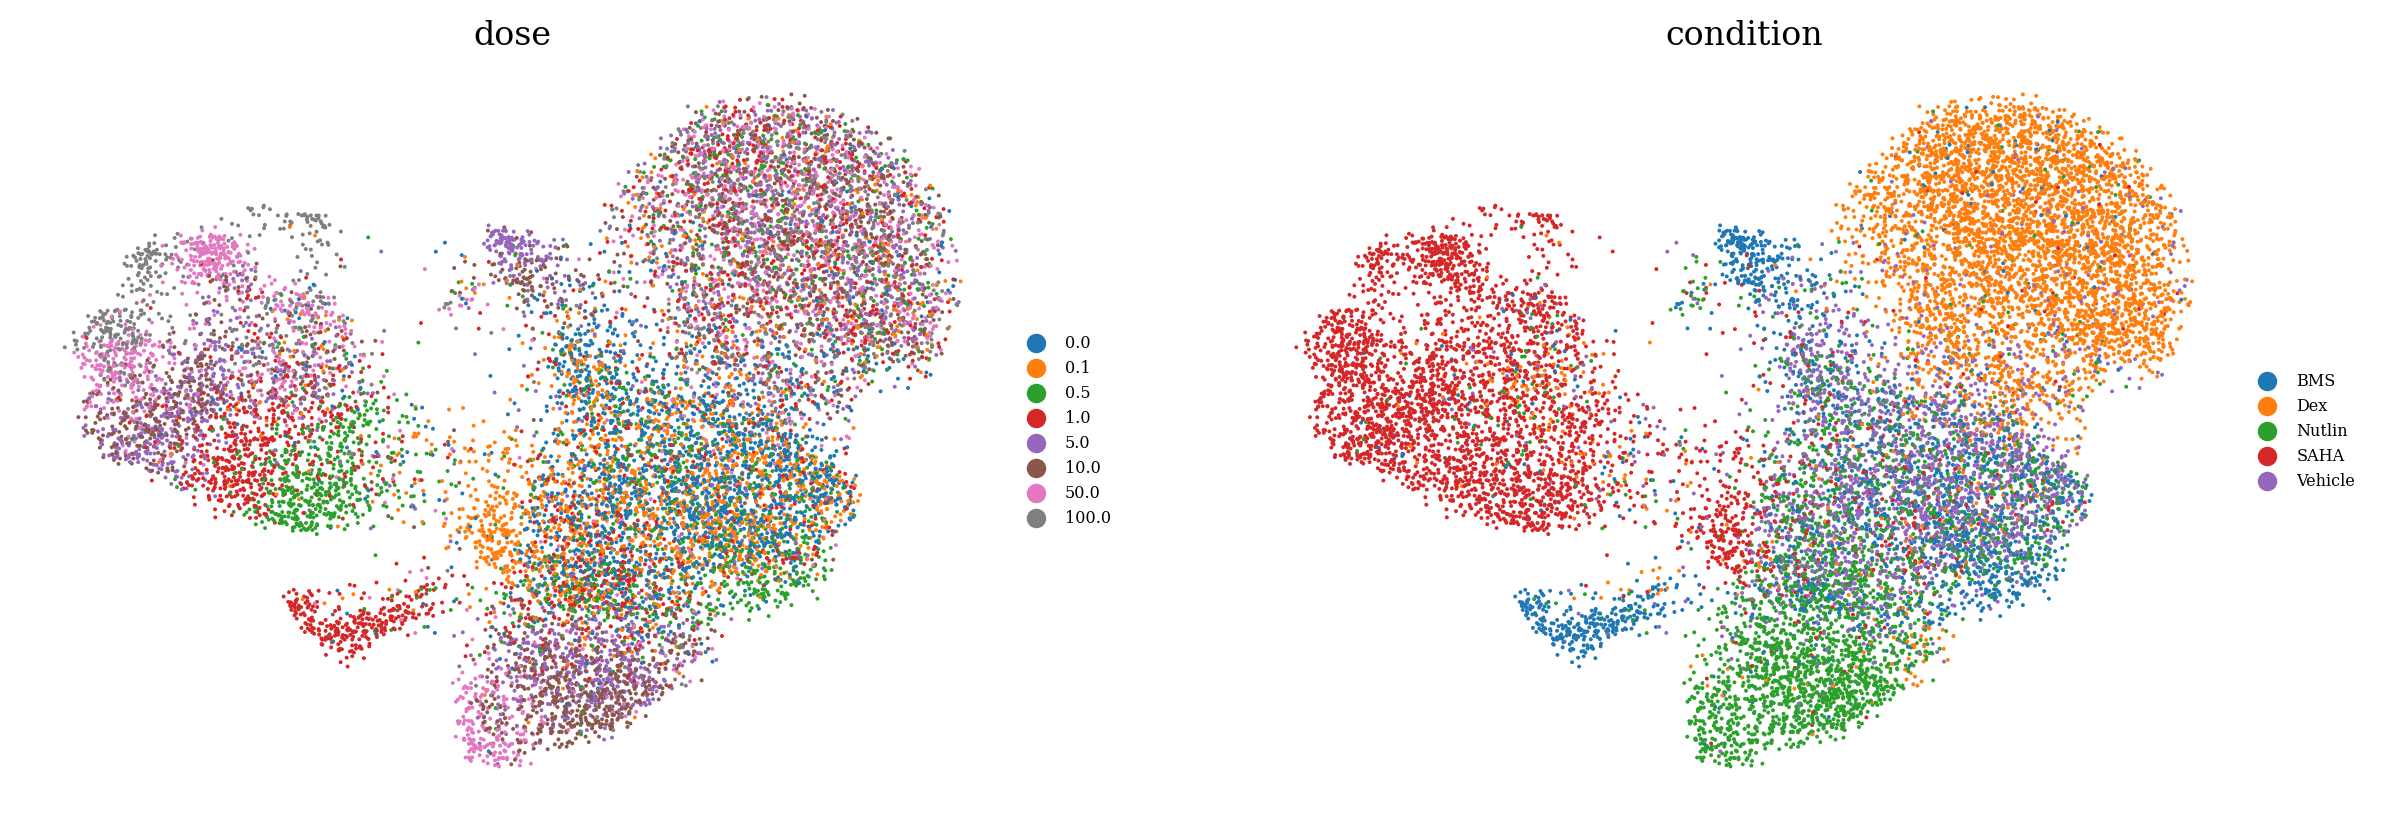

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

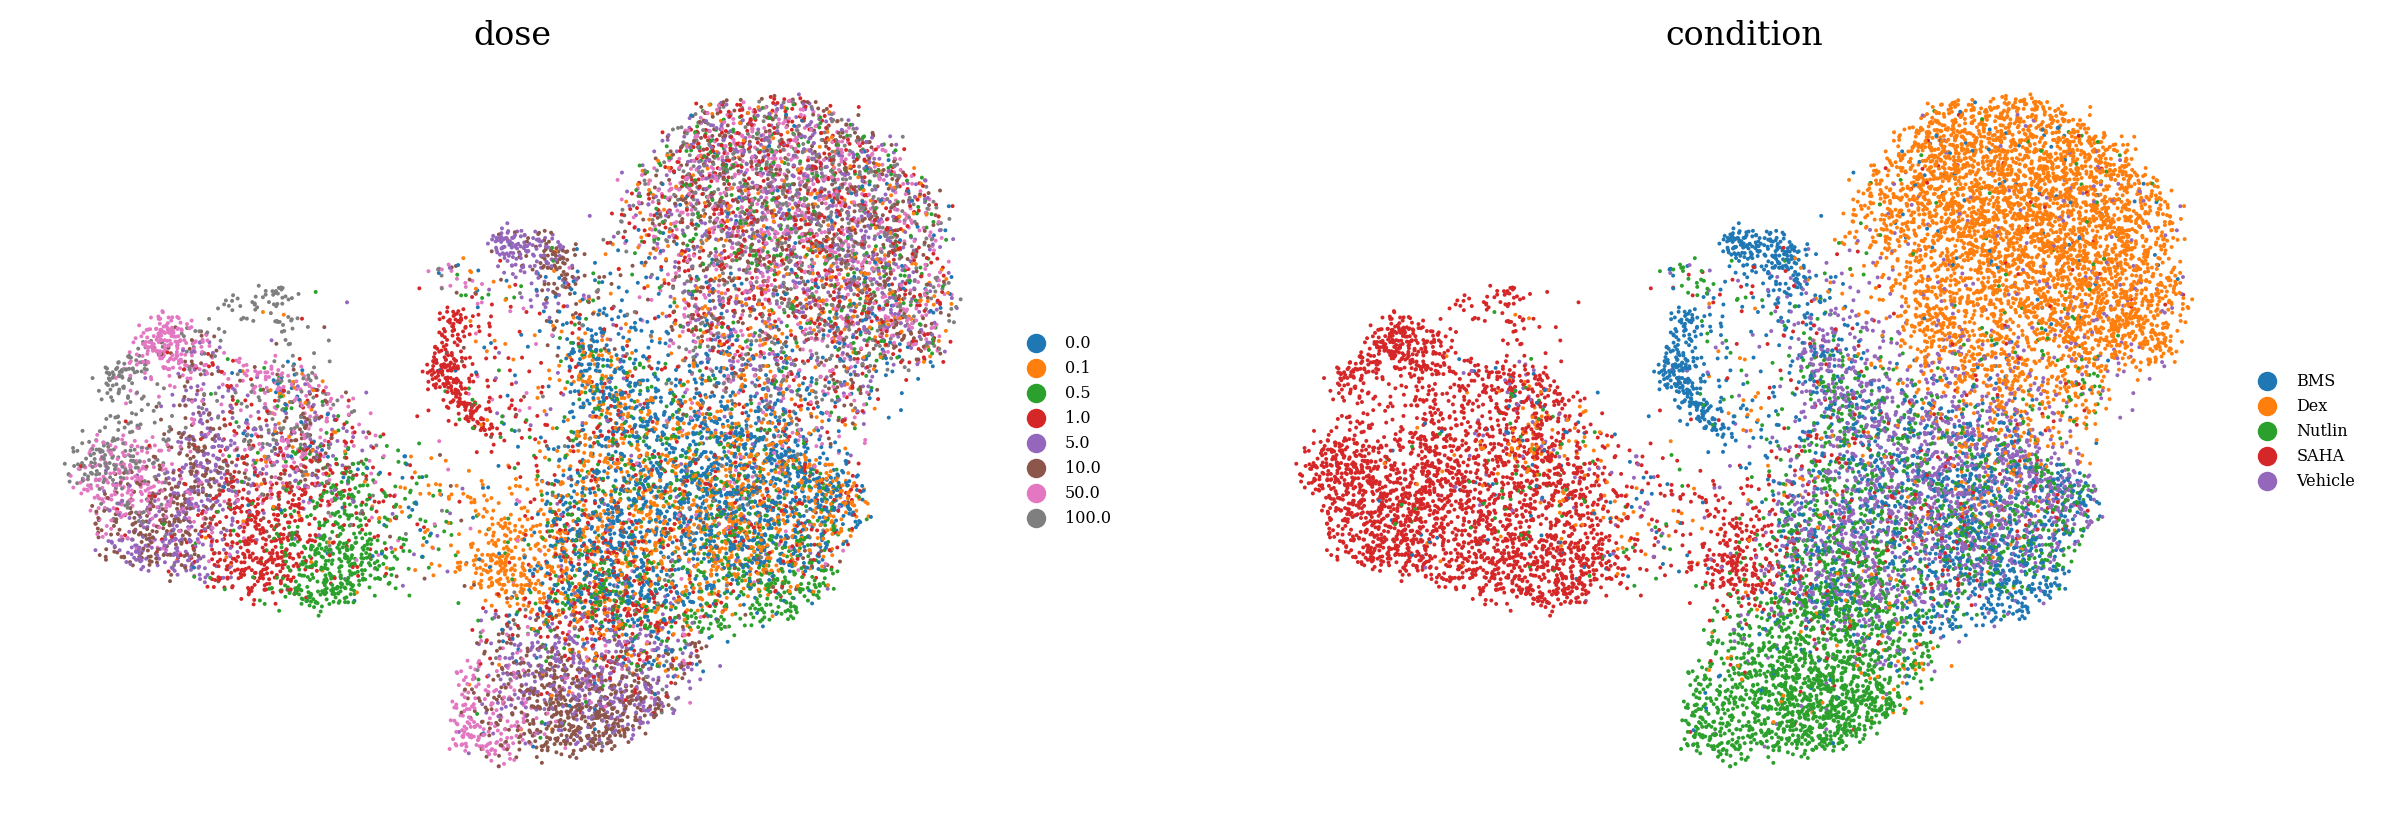

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<03:31,  2.18it/s]

  1%|          | 3/463 [00:00<01:44,  4.42it/s]

  3%|▎         | 16/463 [00:00<00:15, 28.01it/s]

  9%|▉         | 42/463 [00:00<00:05, 76.97it/s]

 15%|█▍        | 68/463 [00:01<00:03, 118.43it/s]

 20%|██        | 93/463 [00:01<00:02, 150.67it/s]

 25%|██▌       | 118/463 [00:01<00:01, 176.17it/s]

 31%|███       | 143/463 [00:01<00:01, 195.56it/s]

 36%|███▌      | 166/463 [00:01<00:03, 93.23it/s] 

 41%|████▏     | 191/463 [00:01<00:02, 117.14it/s]

 46%|████▌     | 211/463 [00:02<00:03, 73.89it/s] 

 51%|█████     | 235/463 [00:02<00:02, 94.64it/s]

 56%|█████▌    | 260/463 [00:02<00:01, 118.02it/s]

 62%|██████▏   | 285/463 [00:02<00:01, 141.13it/s]

 67%|██████▋   | 310/463 [00:02<00:00, 162.73it/s]

 72%|███████▏  | 333/463 [00:03<00:00, 140.51it/s]

 77%|███████▋  | 358/463 [00:03<00:00, 162.52it/s]

 82%|████████▏ | 379/463 [00:04<00:02, 41.04it/s] 

 85%|████████▌ | 394/463 [00:04<00:01, 47.73it/s]

 90%|█████████ | 419/463 [00:05<00:00, 65.74it/s]

 96%|█████████▌| 444/463 [00:05<00:00, 86.28it/s]

100%|██████████| 463/463 [00:05<00:00, 88.87it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9844140826247334

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)